In [1]:
!jupyter nbconvert --to script pipeline_1_v02.ipynb

[NbConvertApp] Converting notebook pipeline_1_v02.ipynb to script
[NbConvertApp] Writing 36559 bytes to pipeline_1_v02.py


In [28]:
# import libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io
from scipy.signal import stft
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# os.chdir('/content/drive/MyDrive/munia/ECE613_new')
# file_path = os.getcwd() + '/W/W/3m_0_file60.mat'


def load_radar_data(file_path):
    """Load radar data from .mat file."""
    data = scipy.io.loadmat(file_path)
    signal_data = data['received_time_domain_signal']  # Shape: (num_chirps, num_samples)
    return signal_data

## Load Data Here


In [30]:
#TODO: Make this for loop for running multiple files for benchmarking
file_path = os.getcwd() + '/clean_data/W/3m_0_file30.mat'
data_matrix = load_radar_data(file_path)
snr_list = [-15, -5, 0, 5, 10]
fs_slow = 1000.0
# optimal_range_bin = (7,10)
r_values=[1]


## Utils Functions

In [31]:
def plot_original_spectrogram(f, t, spec_db, title="Original Micro-Doppler Spectrogram",
                              freq_lims=None, time_lims=None, caxis=None):
    plt.figure(figsize=(8,6))
    extent = [t.min(), t.max(), f[0], f[-1]]
    plt.imshow(spec_db, origin='lower', aspect='auto', extent=extent, cmap='jet')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Doppler Frequency (Hz)")
    cbar = plt.colorbar(label="Magnitude (dB)")

    if caxis is not None:
        plt.clim(caxis[0], caxis[1])
    if freq_lims:
        plt.ylim(freq_lims)
    if time_lims:
        plt.xlim(time_lims)
    plt.tight_layout()
    # plt.savefig('spectrogram_W_org_30.png')
    plt.show()

def add_awgn(data, snr_db):
    """
    Add white Gaussian noise to 'data' to achieve the desired SNR in dB.
    data: numpy array (can be real or complex).
    snr_db: desired SNR in dB (float).
    Returns: noisy_data (same shape as data).
    """
    # 1) Compute signal power
    sig_power = np.mean(np.abs(data)**2)
    # 2) Compute noise variance for desired SNR
    snr_linear = 10**(snr_db/10.0)
    noise_var = sig_power / snr_linear

    # 3) Generate noise
    if np.iscomplexobj(data):
        # Complex data => complex noise
        noise = (np.sqrt(noise_var/2.0) *
                 (np.random.randn(*data.shape) + 1j*np.random.randn(*data.shape)))
    else:
        # Real data => real noise
        noise = np.sqrt(noise_var)*np.random.randn(*data.shape)

    # 4) Add noise
    noisy_data = data + noise
    return noisy_data

# Example function to do everything: generate & plot multiple noisy spectrograms
def generate_noisy_spectrograms(data_matrix, snr_values, fs_slow=1000.0):
    """
    data_matrix: your original data (num_chirps x num_samples)
    snr_values: list of SNRs in dB, e.g. [-15, -5, 0, 5, 10]
    fs_slow: slow-time sampling frequency
    """
    for snr_db in snr_values:
        # Create a noisy copy
        data_noisy = add_awgn(data_matrix, snr_db)

        # Then pass 'data_noisy' to your spectrogram function (like test_compute_spectrogram_2)
        f_centered, t, spec_db_centered, prt_original = compute_spectrogram(data_noisy, r_values=[1], fs_slow=fs_slow)

        # Plot
        plt.figure(figsize=(8,6))
        extent = [t.min(), t.max(), f_centered[0], f_centered[-1]]
        plt.imshow(spec_db_centered, origin='lower', aspect='auto', extent=extent, cmap='jet')
        plt.title(f"Centered Micro-Doppler Spectrogram (SNR={snr_db} dB)")
        plt.xlabel("Time (s)")
        plt.ylabel("Doppler Frequency (Hz)")
        cbar = plt.colorbar(label="Magnitude (dB)")
        plt.clim(-60, -20)  # or adjust
        # plt.ylim([-400, 400]) # if you want to zoom
        plt.xlim([0, 8])      # if you have 8 s
        plt.tight_layout()
        plt.show()



### Optimal Range-Bin

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# **Function 1: Compute and visualize the full FFT processing**
def compute_full_fft(signal_data):
    """
    Compute and visualize the full FFT processing (Range FFT + Doppler FFT).

    Parameters:
    - signal_data: numpy array of shape (num_chirps, num_samples)
    """
    num_chirps, num_samples = signal_data.shape

    # Compute Range FFT (Fast-Time FFT)
    range_fft = np.fft.fft(signal_data, axis=1)  # FFT along samples
    range_fft_magnitude = np.abs(range_fft)  # Get magnitude

    # Plot Range FFT
    # plt.figure(figsize=(10, 5))
    # plt.imshow(20 * np.log10(range_fft_magnitude), aspect='auto', cmap='jet')
    # plt.title("Range FFT (Fast Time)")
    # plt.xlabel("Samples (Range Bins)")
    # plt.ylabel("Chirps")
    # plt.colorbar(label="Magnitude (dB)")
    # plt.show()

    return range_fft_magnitude


# **Function 2: Compute STFT of the given signal**
def compute_stft(signal_data, fs=1e6, window='hann'):
    """
    Compute the Short-Time Fourier Transform (STFT) of the given signal.

    Parameters:
        signal_data (ndarray): Input time-domain signal.
        fs (float): Sampling frequency.
        nperseg (int): Window length for STFT.
        window (str): Window function type.
        noverlap (int or None): Overlap between segments.

    Returns:
        f (ndarray): Frequency bins.
        t (ndarray): Time bins.
        Zxx (ndarray): Complex STFT result.
        Zxx_magnitude (ndarray): Magnitude of STFT in dB.
    """
    # if noverlap is None:
    #     noverlap = nperseg // 2  # Default 50% overlap

    # # Ensure noverlap is strictly less than nperseg
    # if noverlap >= nperseg:
    #     noverlap = nperseg - 1  # This ensures noverlap is strictly less than nperseg

    f, t, Zxx = stft(signal_data, fs=fs, window=window, return_onesided=False)

    # Convert magnitude to dB, ensuring numerical stability
    Zxx_magnitude = 10 * np.log10(np.abs(Zxx) + np.finfo(float).eps)

    return f, t, Zxx, Zxx_magnitude


# **Function 3: Compute entropy for the STFT result**
def compute_entropy(Zxx, tau_index):
    """
    Compute Shannon entropy of the frequency distribution at a specific time index.

    Parameters:
        Zxx (ndarray): STFT complex result.
        tau_index (int): Index corresponding to time τ.

    Returns:
        entropy (float): Shannon entropy in bits.
    """
    magnitude_spectrum = np.abs(Zxx[:, tau_index])

    # Normalize to obtain probability distribution
    P = magnitude_spectrum / np.sum(magnitude_spectrum)
    P = P[P > 0]  # Remove zero elements to avoid log(0)

    # Compute entropy
    entropy = -np.sum(P * np.log2(P))

    return entropy

# **Function 4: Compute average entropy for the STFT result**
def compute_average_entropy(Zxx, t):
    """
    Compute the average entropy across all time bins.

    Parameters:
        Zxx (ndarray): STFT complex result.
        t (ndarray): Time bins.

    Returns:
        average_entropy (float): Average Shannon entropy over time.
    """
    entropies = []
    for tau_index in range(len(t)):
        entropy = compute_entropy(Zxx, tau_index)
        entropies.append(entropy)

    average_entropy = np.mean(entropies)
    return average_entropy

# **Function 5: Process all chirps, including FFT, STFT, and entropy calculations**
def get_optimal_range_bin(data_matrix, r_values):
    """
    Process all chirps in the data matrix: Compute FFT, STFT, entropy, and average entropy.

    Parameters:
        data_matrix (ndarray): Input data matrix of shape (num_chirps, num_samples).
        r_values (list): List of range intervals for defining r_q.
    """
    num_chirps, num_samples = data_matrix.shape
    P_max = []

    # Compute full FFT for all chirps
    range_fft_magnitude = compute_full_fft(data_matrix)

    # Step 2a: Find P_max for each chirp
    for i in range(num_chirps):
        P_max_value = np.max(range_fft_magnitude[i, :])  # Maximum value in the FFT magnitude
        P_max.append(P_max_value)

    # Step 2b: Find most frequent index in P_max
    idx_max = np.argmax(np.bincount(np.array(P_max, dtype=int)))  # Most frequent index

    # Step 3: For each q in Q, define range r_q and compute STFT
    min_entropy = float('inf')  # Initialize min_entropy
    best_r_opt = None  # Initialize best range

    for q in range(len(r_values)):
        r_q = np.arange(idx_max - r_values[q], idx_max + r_values[q])  # Fix: cast idx_max to int

        # Select the range of the signal for the defined r_q
        signal_range = data_matrix[:, r_q]

        # Compute STFT for this range
        for chirp_index in range(num_chirps):
            signal_data = signal_range[chirp_index]
            f, t, Zxx, Zxx_magnitude = compute_stft(signal_data)

            # Step 3b: Calculate average entropy for the range r_q
            avg_entropy = compute_average_entropy(Zxx, t)
            # print(f"Average Entropy for range r_q = {r_values[q]}: {avg_entropy:.4f} bits")

            # Update optimal range-bin if entropy is lower
            if avg_entropy < min_entropy:
                min_entropy = avg_entropy
                best_r_opt = r_q

    # Compute the optimal range-bin interval (Equation 11)
    optimal_range_bin = (idx_max - best_r_opt[0], idx_max + best_r_opt[-1])  # Fix the interval calculation
    return optimal_range_bin

def compute_spectrogram(data_matrix, r_values, fs_slow=1000.0):
    """
    data_matrix: shape (num_chirps, num_fast_time_samples) if raw,
                 or shape (num_chirps, num_range_bins) if already range-FFT.
    r_values: list of half-widths around idx_max.
    fs_slow: slow-time sampling rate (e.g. 1000 Hz).
    """
    num_chirps, num_samples = data_matrix.shape
    P_max = []
    # print("data_matrix shape:", data_matrix.shape)

    # 1) If data_matrix is raw, do range FFT:
    #    But if your data is already range-FFT, skip this.
    # Example:
    # range_fft_data = np.fft.fft(data_matrix, axis=1)
    # range_fft_mag = np.abs(range_fft_data)
    # For demonstration, let's assume data_matrix is ALREADY range-FFT:
    # range_fft_mag = np.abs(data_matrix)
    # Compute full FFT for all chirps
    range_fft_magnitude = compute_full_fft(data_matrix)
    range_fft_data = np.fft.fft(data_matrix.T, axis=1)
    # Step 2a: Find P_max for each chirp
    for i in range(num_chirps):
        P_max_value = np.max(range_fft_magnitude[i, :])  # Maximum value in the FFT magnitude
        P_max.append(P_max_value)

    # Step 2b: Find most frequent index in P_max
    idx_max = np.argmax(np.bincount(np.array(P_max, dtype=int)))  # Most frequent index


    # 2) Find the bin with max average magnitude
    # avg_mag_bins = np.mean(range_fft_mag, axis=0)  # shape: (num_range_bins,)
    # idx_max = np.argmax(avg_mag_bins)
    # print("idx_max:", idx_max)

    # 3) Pick a small interval around idx_max
    #    e.g., if r_values = [1], we do ±1 bin around idx_max
    #    Or we just pick r_values[0].
    half_width = r_values[0]
    start = max(0, idx_max - half_width)
    # end   = min(num_samples, idx_max + half_width + 1)
    end   = min(num_samples, idx_max + half_width)

    # print(start)
    # print(end)
    # 4) Accumulate STFT magnitudes across these bins
    accum = None
    count = 0

    nperseg = 128
    noverlap = 64

    for rb in range(start, end):
        slow_time_signal = range_fft_data[:, rb].copy()

        # Ensure nperseg <= length of slow_time_signal
        nperseg_local = min(nperseg, len(slow_time_signal))
        noverlap_local = min(noverlap, nperseg_local - 1)

        # Compute full STFT
        f, t, Zxx = stft(
            slow_time_signal,
            fs=fs_slow,
            nperseg=nperseg_local,
            noverlap=noverlap_local,
            window='hann',
            return_onesided=False
        )

        # Center the Doppler axis
        Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
        f_shifted = np.fft.fftshift(f)

        # Accumulate magnitudes
        mag = np.abs(Zxx_shifted)
        if accum is None:
            accum = mag
        else:
            accum += mag
        count += 1

    # Average across selected bins
    avg_mag = accum / max(count, 1)

    power_spec = avg_mag**2

    # Convert to dB => see both signal and noise
    spec_db = 20.0 * np.log10(avg_mag + 1e-12)
    return f_shifted, t, spec_db, power_spec

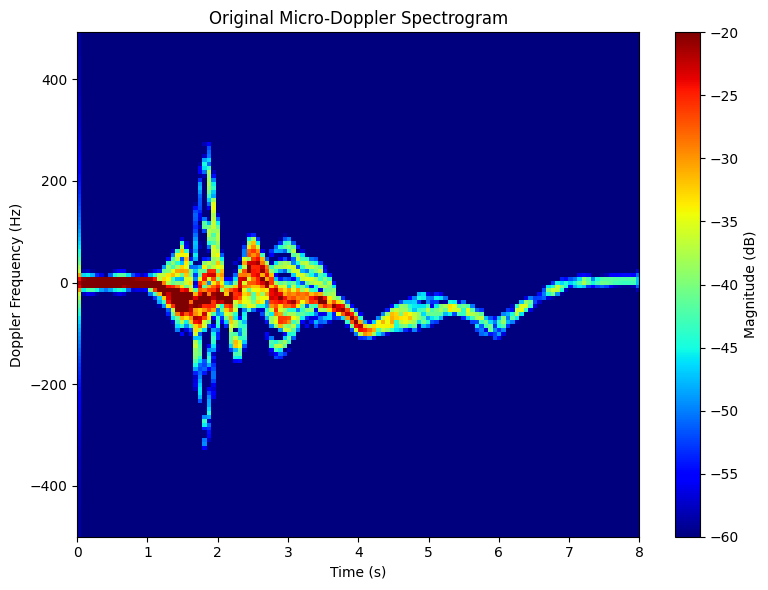

In [33]:
f_centered, t, spec_db_centered, power_spec =  compute_spectrogram(data_matrix,r_values,fs_slow=1000.0)

plot_original_spectrogram(
    f_centered, t, spec_db_centered,
    title="Original Micro-Doppler Spectrogram",
    time_lims=(0, 8),
    caxis=(-60, -20)
)

## Generate Noisy Spectrograms


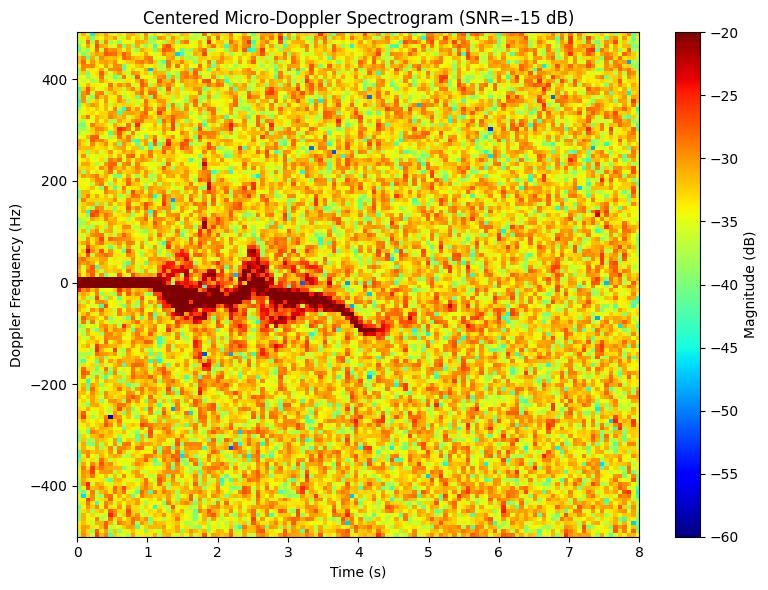

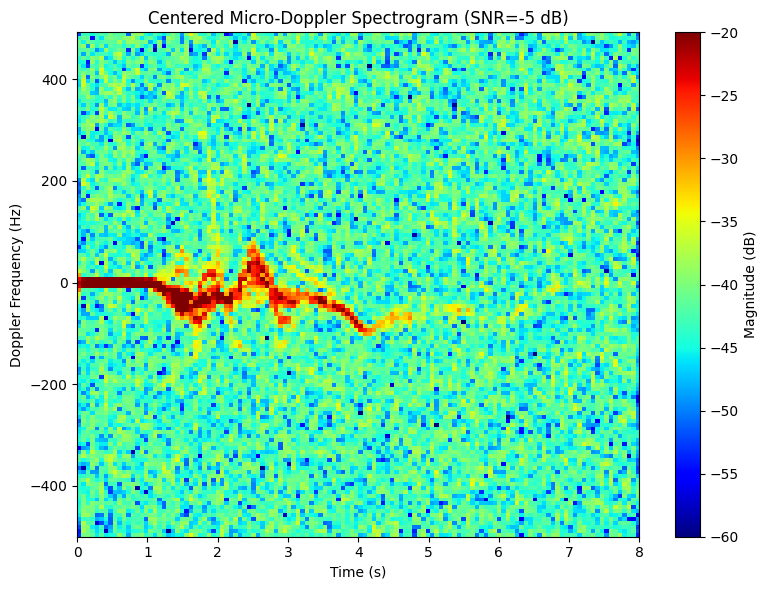

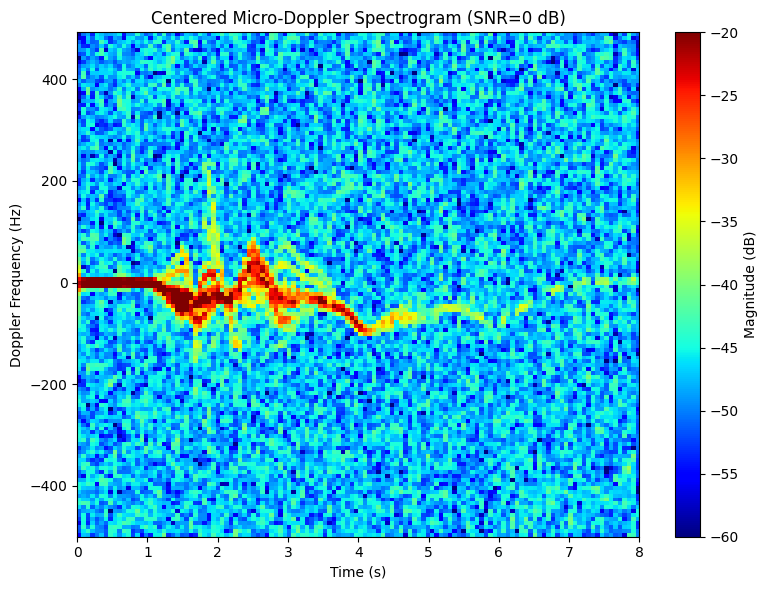

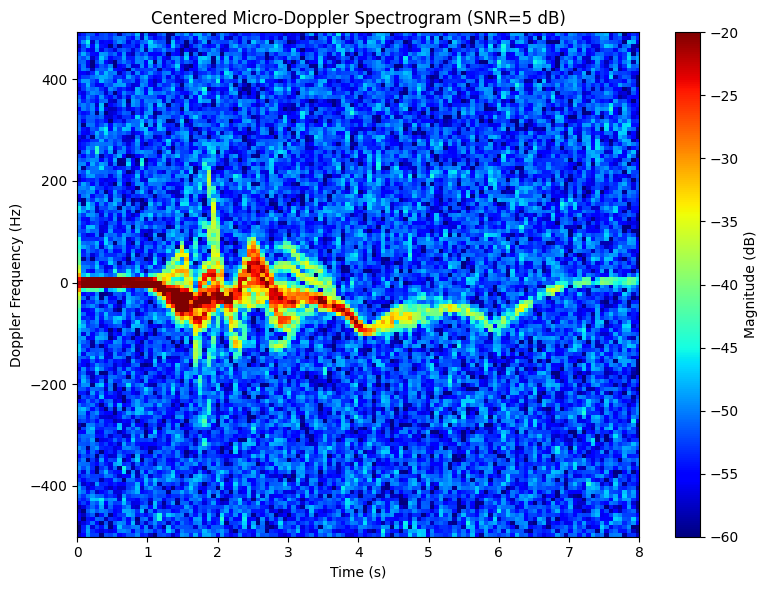

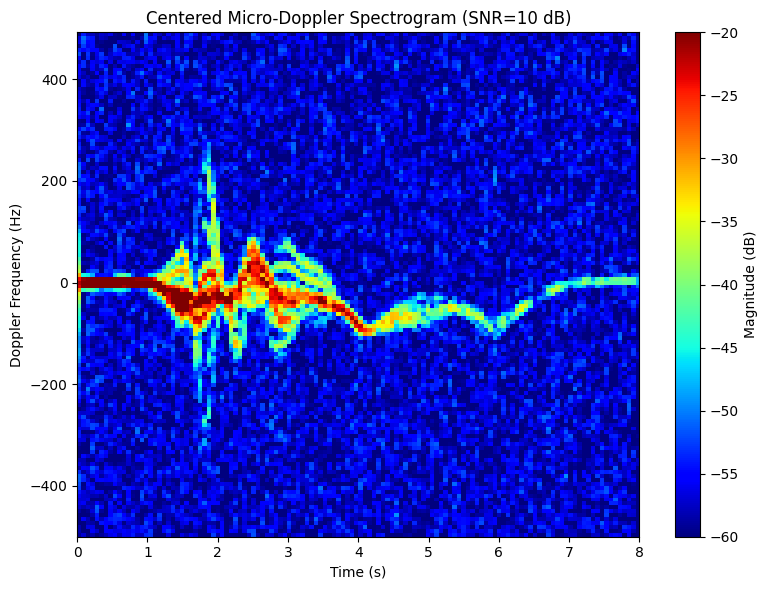

In [34]:
generate_noisy_spectrograms(data_matrix, snr_list, fs_slow=1000.0)

In [35]:
noisy_data_dict = {}
snr_levels = [-15, -5, 0, 5, 10]
for snr in snr_levels:
        noisy_data = add_awgn(data_matrix, snr)
        noisy_data_dict[snr] = noisy_data
        # Optionally, save to file:
        # filename = f"data_noise_{snr}dB.npy"
        # np.save(filename, noisy_data)
        # print(f"Saved noisy data at {snr} dB to {filename}")

# Now you have variables like:
data_noise_minus15_dB = noisy_data_dict[-15]
data_noise_minus5_dB  = noisy_data_dict[-5]
data_noise_0_dB       = noisy_data_dict[0]
data_noise_5_dB       = noisy_data_dict[5]
data_noise_10_dB      = noisy_data_dict[10]

## Entropy-based denoising algorithm

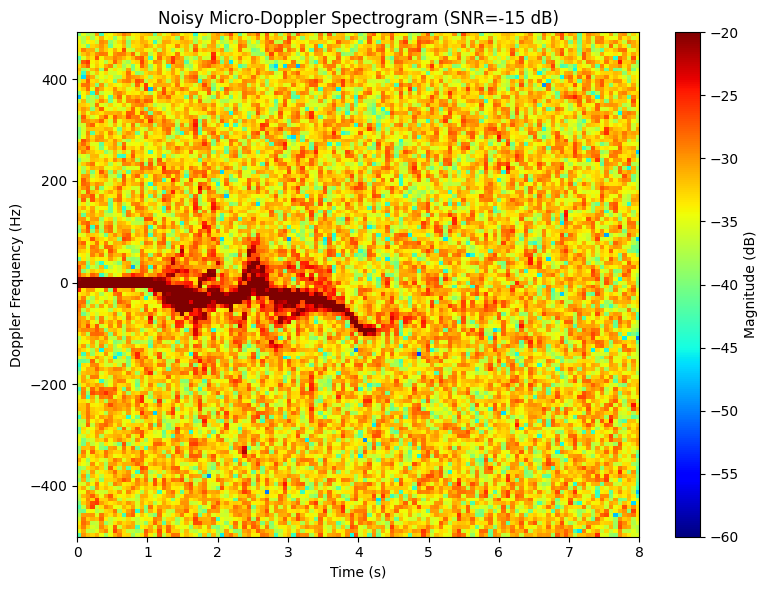

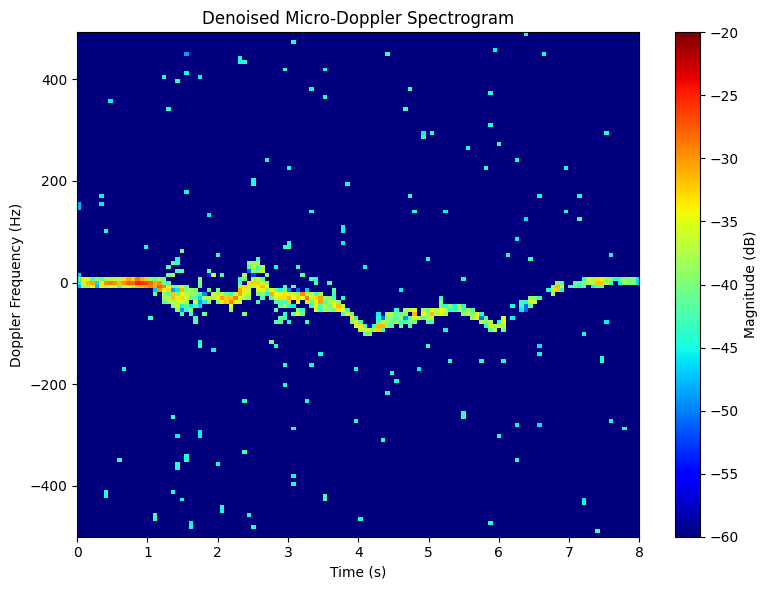

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

"""
- We use 50% overlap instead of 90%
- We use Hann window instead of G window
"""
def algo_EBD(signal_data, optimal_range, Th=3, fs_slow=1000.0):
    """
    Entropy-based denoising algorithm: Denoise using adaptive STFT thresholding.
    Instead of plotting directly, returns the thresholded STFT in complex form,
    plus frequency/time arrays so you can plot a spectrogram that matches your
    'raw/noisy' style.

    Parameters:
      signal_data: shape (num_chirps, num_samples)
      optimal_range: (start, end) for the selected range bins
      Th: threshold factor
      fs_slow: slow-time sampling rate (1000 Hz since 1 ms per chirp)

    Returns:
      denoised_stft_accum: complex 2D array (freq_bins x time_frames),
                           after thresholding & averaging across the selected bins
      f: frequency bins (in Hz)
      t: time bins (in s)
    """
    num_chirps, num_samples = signal_data.shape
    # print(f"Before input function: {np.shape(signal_data)}")
    # 1) Range FFT (fast-time)
    range_fft = np.fft.fft(signal_data.T, axis=1)  # shape: (num_chirps, num_samples)

    start, end = optimal_range
    selected_bins = range(start, end)

    denoised_stft_accum = None
    count_bins = 0

    # For each selected range bin, do STFT of slow-time signal & threshold
    for rb in selected_bins:
        slow_time_signal = range_fft[:, rb]

        nperseg = min(128, len(slow_time_signal))
        # noverlap = int(0.9 * nperseg)
        noverlap = int(0.5 * nperseg)
        f, t, Zxx = signal.stft(
            slow_time_signal,
            fs=fs_slow,
            nperseg=nperseg,
            noverlap=noverlap,
            # window=('gaussian', 14),
            window='hann',
            return_onesided=False
        )

        # Adaptive thresholding for each time frame
        Zxx_denoised = np.zeros_like(Zxx, dtype=complex)
        for i in range(Zxx.shape[1]):
            frame = Zxx[:, i].copy()
            mag = np.abs(frame)
            avg_mag = np.mean(mag)
            threshold = Th * avg_mag
            mask = (mag > threshold)
            frame[~mask] = 0
            Zxx_denoised[:, i] = frame

        if denoised_stft_accum is None:
            denoised_stft_accum = np.zeros_like(Zxx_denoised, dtype=complex)
        denoised_stft_accum += Zxx_denoised
        count_bins += 1

    if count_bins > 0:
        denoised_stft_accum /= count_bins
    else:
        print("Warning: No bins were selected. Returning None.")
        return None, None, None

    # print(f"After function {np.shape(denoised_stft_accum)}")

    return denoised_stft_accum, f, t

def plot_denoised_spectrogram(denoised_stft_accum, f, t, title="Denoised Micro-Doppler Spectrogram",caxis=None):
    """
    Plot the denoised STFT in the same style as your raw/noisy spectrogram.
    """
    denoised_mag = np.abs(denoised_stft_accum)
    # range_fft_data = np.fft.fft(denoised_stft_accum.T, axis=1)

    # f, t, Zxx = stft(
    #     slow_time_signal,
    #     fs=fs_slow,
    #     nperseg=nperseg_local,
    #     noverlap=noverlap_local,
    #     window='hann',
    #     return_onesided=False
    # )

    # denoised_db = 20.0 * np.log10(np.abs(range_fft_data) + 1e-12)
    denoised_db = 20.0 * np.log10(denoised_mag + 1e-12)

    # fftshift along freq axis
    denoised_db_shifted = np.fft.fftshift(denoised_db, axes=0)
    f_shifted = np.fft.fftshift(f)

    # Plot
    # plt.figure(figsize=(10,5))
    plt.figure(figsize=(8,6))
    extent = [t[0], t[-1], f_shifted[0], f_shifted[-1]]
    plt.imshow(denoised_db_shifted, origin='lower', aspect='auto',
               extent=extent, cmap='jet')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Doppler Frequency (Hz)")
    plt.colorbar(label="Magnitude (dB)")
    if caxis is not None:
        plt.clim(caxis[0], caxis[1])
    # plt.ylim([-400, 400]) # if you want to zoom
    plt.xlim([0, 8])      # if you have 8 s
    plt.tight_layout()
    plt.show()


# data_noise_ = noisy_data_dict[-15]
data_noise_ = data_noise_minus15_dB
f_noisy, t_noisy, spec_db_noisy, prt_noisy =  compute_spectrogram(data_noise_, r_values=[1], fs_slow=fs_slow)

# Plot and save the noisy spectrogram image
plt.figure(figsize=(8,6))
extent = [t_noisy.min(), t_noisy.max(), f_noisy[0], f_noisy[-1]]
plt.imshow(spec_db_noisy, origin='lower', aspect='auto', extent=extent, cmap='jet')
plt.title("Noisy Micro-Doppler Spectrogram (SNR=-15 dB)")
plt.xlabel("Time (s)")
plt.ylabel("Doppler Frequency (Hz)")
plt.colorbar(label="Magnitude (dB)")
plt.clim(-60, -20)
plt.xlim([0, 8])
plt.tight_layout()
# plt.savefig(f"data_noise_minus15_dB.png", dpi=150)
plt.show()
# print("Noisy spectrogram image saved as 'noisy_spectrogram.png'.")

# Call EBD algorithm here
optimal_range = get_optimal_range_bin(data_noise_, r_values)
# print(optimal_range)
Th = 3  # Threshold value determined empirically.
denoised_stft, f_den, t_den = algo_EBD(data_noise_, optimal_range, Th=3, fs_slow=1000.0)

plot_denoised_spectrogram(denoised_stft, f_den, t_den, title="Denoised Micro-Doppler Spectrogram",caxis=(-60, -20))

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def get_global_threshold_db(spec_db, V=0.1):
    """
    Iteratively find a global threshold T in a 2D array of dB values (spec_db).
    Flatten the array, repeatedly split around 'mu' until difference < V.
    Returns T in dB (float).
    """
    flattened = spec_db.flatten().astype(np.float32)
    mu = np.mean(flattened)
    diff = V + 1
    T = 0
    while diff > V:
        if T != 0:
            mu = T
        group1 = flattened[flattened > mu]
        group2 = flattened[flattened <= mu]
        if group1.size == 0 or group2.size == 0:
            break
        T_new = 0.5 * (np.mean(group1) + np.mean(group2))
        diff = abs(T_new - mu)
        T = T_new
    # print(f"[Algo3] Final global threshold T in dB = {T:.2f}")
    return T

def algo_ADTh(spec_db, vmin=-60, vmax=-20, tol=0.1, plot=False):
    """
    spec_db: 2D array (freq_bins x time_bins) in dB
    vmin, vmax: color scale range
    tol: iteration tolerance for get_global_threshold_db

    1) Find threshold T from spec_db
    2) For all pixels < T, set them to vmin (e.g., -60 dB).
    3) Optionally plot the denoised spectrogram.
    4) Return the denoised 2D array (same shape as spec_db).
    """

    # 1) Find threshold T
    T = get_global_threshold_db(spec_db, V=tol)

    # 2) Clamp values below T
    denoised_data = spec_db.copy()
    denoised_data[denoised_data < T] = vmin

    # 3) Optionally plot
    if plot:
        fig, ax = plt.subplots(figsize=(8,6))
        im = ax.imshow(denoised_data, origin='lower', aspect='auto',
                       cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title("Denoised Micro-Doppler (Algorithm 3: Global Threshold)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Doppler Frequency (Hz)")
        cbar = fig.colorbar(im, ax=ax, label="Magnitude (dB)")
        fig.tight_layout()
        plt.show()

    # 4) Return denoised array
    return denoised_data


## Resolution-adaptive spectrogram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from scipy.io import loadmat
from skimage.transform import resize

def generate_ra_spectrogram(SPEC, num_filter, nfft, fmax):
    # Generate RA Spectrogram
    # - RASPEC: Resultant RA spectrogram
    # - energyDist: Energy distribution along the frequency domain

    # SPEC is the PRT from the compute_spectrogram() function

    # Calculate energy distribution across the frequency domain
    energyDist = np.sum(SPEC, axis=1)

    # Ensure energyDist is a 1D NumPy array
    # Find number of change points (2 max for the corner frequencies)
    algo = rpt.Binseg(model="l2").fit(energyDist)
    fcs = algo.predict(n_bkps=2)[:-1]  # Drop last segment endpoint (len(energyDist))
    fcs = np.array(fcs).reshape(2,1)

    # Choose corner frequency
    cornerFreq = 2 * fmax / (nfft - 1) * np.max(np.abs(nfft / 2 - fcs))

    # Generate filterbank based on the calculated corner frequency
    filter_bank = filterbank_gen(num_filter, fmax, nfft, cornerFreq)

    # Split spectrogram into negative and positive frequencies
    # - SPEC_neg: Negative frequency components (lower half of the spectrum)
    # - SPEC_pos: Positive frequency components (upper half of the spectrum)
    SPEC_neg = np.flip(SPEC[:nfft//2, :], axis=0)
    SPEC_pos = SPEC[nfft//2:, :]

    # Apply filterbank to both negative and positive frequency components
    SPEC_neg = np.dot(filter_bank, SPEC_neg)
    SPEC_pos = np.dot(filter_bank, SPEC_pos)

    # Construct RA spectrogram by concatenating negative and positive frequency components
    RASPEC = np.vstack((np.flip(SPEC_neg, axis=0), SPEC_pos))

    # Convert to logartithmic scale and make sure shape is (128,126)
    RASPEC = resize(10 * np.log10(np.abs(RASPEC) + 1e-12), (128, 126), mode='reflect', anti_aliasing=True)

    return RASPEC, energyDist

def filterbank_gen(numFilter, fmax, nfft, cornerFreq, plot_filters = False):
    # Generate FilterBank for RA Spectrogram

    # Maximum scale value
    S_max = scale_fun(fmax, cornerFreq)

    # Nonlinear scale points for filterbank design
    NL_points = np.linspace(0, S_max, numFilter + 2)

    # Linear scale points obtained by applying inverse scaling
    L_points = inv_scale_fun(NL_points, cornerFreq)

    # Create filterbank matrix
    FFTbin = np.floor((nfft + 1) * L_points / (2 * fmax)).astype(int)
    filter_bank = np.zeros((numFilter, nfft // 2))

    # Populate filterbank
    for m in range(1, numFilter + 1):
        # Ascending part of filter
        for k in range(FFTbin[m-1] + 1, FFTbin[m] + 1):
            filter_bank[m-1, k-1] = (k - FFTbin[m-1]) / (FFTbin[m] - FFTbin[m-1])

        # Descending part of filter
        for k in range(FFTbin[m] + 1, FFTbin[m+1] + 1):
            filter_bank[m-1, k-1] = (FFTbin[m+1] - k) / (FFTbin[m+1] - FFTbin[m])

    # ------------------------------FOR DEBUGGING FILTERS ----------------------------------------------
    # set plot_filters to true in the arguments for debugging
    if plot_filters:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        for i in range(min(20, numFilter)):
            plt.plot(filter_bank[i], label=f'Filter {i}')
        plt.title('First 10 Filter Bank Channels')
        plt.xlabel('FFT bin index')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.show()
    # -----------------------------------------------------------------------------------------------------

    return filter_bank

# Helper function for scale
def scale_fun(hz, cornerFreq):
    return cornerFreq / np.log10(2) * np.log10(1 + hz / cornerFreq)

# Helper function for inverse scaling
def inv_scale_fun(D, cornerFreq):
    return cornerFreq * (10**(D / (cornerFreq / np.log10(2))) - 1)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim

def compute_global_metrics(ref, test, data_is_db=True):
    """
    Compute common image-quality metrics between reference and test images (2D arrays).
    Assumes both are in the same scale (dB or linear).

    Args:
        ref (2D np.array): Reference spectrogram (noise-free).
        test (2D np.array): Test spectrogram (noisy or denoised).
        data_is_db (bool): If True, interpret the arrays as dB images. This affects PSNR calculation.

    Returns:
        metrics (dict): Dictionary containing MSE, MAE, PSNR, Correlation, SSIM.
    """
    # Ensure shapes match
    if ref.shape != test.shape:
        raise ValueError(f"Shapes differ! ref={ref.shape}, test={test.shape}")

    # Flatten for some metrics
    ref_flat = ref.flatten()
    test_flat = test.flatten()

    # 1) MSE
    mse_val = np.mean((ref_flat - test_flat) ** 2)

    # 2) MAE
    mae_val = np.mean(np.abs(ref_flat - test_flat))

    rmse_val = np.sqrt(mse_val)

    # 3) PSNR
    #   In dB images, you can either:
    #     (A) Use max of reference in dB, or
    #     (B) Convert from dB -> linear, then compute PSNR in linear scale.
    #   Here, we do a "dB-domain" style PSNR using the max ref value in dB:
    ref_max = np.max(ref)
    if mse_val == 0:
        psnr_val = np.inf
    else:
        psnr_val = 10.0 * np.log10((ref_max**2) / mse_val)

    # 4) Correlation Coefficient
    corr_val, _ = pearsonr(ref_flat, test_flat)

    # 5) SSIM
    #   SSIM in skimage requires specifying data_range = max - min for correct results.
    #   If your data is in dB, data_range is (max_dB - min_dB).
    data_range = ref_max - np.min(ref)
    ssim_val = ssim(ref, test, data_range=data_range)

    metrics = {
        'MSE': mse_val,
        'MAE': mae_val,
        'RMSE': rmse_val,
        'PSNR': psnr_val,
        'Correlation': corr_val,
        'SSIM': ssim_val
    }
    return metrics

from scipy.interpolate import RegularGridInterpolator

def unify_spectrograms(spec1, spec2, T_common=200, F_common=256):
    """
    Interpolate two spectrograms to the same shape (T_common x F_common).
    Returns (spec1_unified, spec2_unified).
    """
    t1_size, f1_size = spec1.shape
    t2_size, f2_size = spec2.shape

    # Original coordinate grids
    t1 = np.linspace(0, 1, t1_size)
    f1 = np.linspace(0, 1, f1_size)
    t2 = np.linspace(0, 1, t2_size)
    f2 = np.linspace(0, 1, f2_size)

    # Interpolating to new grid
    new_t = np.linspace(0, 1, T_common)
    new_f = np.linspace(0, 1, F_common)
    TT, FF = np.meshgrid(new_t, new_f, indexing='ij')  # shape (T_common, F_common)

    interp1 = RegularGridInterpolator((t1, f1), spec1)
    interp2 = RegularGridInterpolator((t2, f2), spec2)

    points = np.stack([TT.ravel(), FF.ravel()], axis=-1)
    spec1_unif = interp1(points).reshape(T_common, F_common)
    spec2_unif = interp2(points).reshape(T_common, F_common)

    return spec1_unif, spec2_unif


import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr

def main():
    # List of spectrogram data sets to test, only the ones in this list will be tested
    # STW dataset seems to have some corrupt data, so it is excluded
    spectrogram_types = ["B", "FTW", "G", "K", "P", "SD", "SU", "W", "WTF", "WTS"]


    try:
        os.mkdir('./noisy_data')
    except FileExistsError:
        pass

    for spec_type in spectrogram_types:
        try:
            os.mkdir(f'./noisy_data/{spec_type}')
        except FileExistsError:
            pass

    for spec_type in spectrogram_types:
        ebd_time_sum = 0
        adth_time_sum = 0
        sample_count = 0
        ebd_time_list = []
        adth_time_list = []

        _, _, files = next(os.walk(os.getcwd() + f'/clean_data/{spec_type}/'))
        file_count = len(files)

        for i in range(1, file_count + 1):
            # 1) Load your data
            file_path = os.getcwd() + f'/clean_data/{spec_type}/3m_0_file{i}.mat'
            print (f"Now executing algos on {spec_type} spectrogram file {f'/clean_data/{spec_type}/3m_0_file{i}.mat'}")
            data_matrix = load_radar_data(file_path)  # shape: (num_chirps, num_samples)
            r_values=[1]

            snr_list = [-15, -5, 0, 5, 10]
            for snr in snr_list:
                res = single_itr(file_path, data_matrix, i, snr, spec_type)
                ebd_time_sum += res[0]
                adth_time_sum += res[1]
                ebd_time_list.append(res[0])
                adth_time_list.append(res[1])
                sample_count += 1

        print(f"\nSummary for [{spec_type}]:")
        print(f"EBD Time List for [{spec_type}]:")
        print(ebd_time_list)
        print("")
        print(f"AdTh Time List for [{spec_type}]:")
        print(adth_time_list)
        print("")
        print(f"Average EBD time for [{spec_type}] ({sample_count} samples): {ebd_time_sum/60} s")
        print(f"Average AdTh time for [{spec_type}] ({sample_count} samples): {adth_time_sum/60} s\n")   


def single_itr(file_path, data_matrix, file_num, snr, spec_type): 
    EBD_REPS = 2
    ADTH_REPS = 100

    # 2) Compute ORIGINAL spectrogram in dB
    f_orig, t_orig, spec_db_original, PRT_original = compute_spectrogram(
        data_matrix, r_values=[1], fs_slow=1000.0
    )
    # spec_db_original is your "noise-free" reference

    # 3) Add noise here if noisy spectrogram does not exist

    # for snr in snr_list:
    filename = f"./noisy_data/{spec_type}/data_noisy{file_num}_{snr}dB.npy"
    if os.path.isfile(filename) == False:
        data_noisy_ = add_awgn(data_matrix, snr_db=snr)
        np.save(filename, data_noisy_)

    # Load from .npy noisy data to keep it consistent
    data_noisy_ = np.load(filename)

    # 4) Compute noisy spectrogram in dB
    f_noisy, t_noisy, spec_db_noisy, PRT_noisy = compute_spectrogram(
        data_noisy_, r_values=[1], fs_slow=1000.0
    )

    # 5) Denoise

    # Start timer for EBD algo
    st1 = time.process_time()

    # Repeat x times and take the average
    for k in range (EBD_REPS):
        optimal_range = get_optimal_range_bin(data_noisy_, r_values)
        # print(optimal_range)
        Th = 3  # Threshold value determined empirically.
        denoised_stft_algo_EBD, f_den, t_den = algo_EBD(data_noisy_, optimal_range, Th=3, fs_slow=1000.0)

        # Convert the complex STFT output to dB
        denoised_stft_algo_EBD_mag = np.abs(denoised_stft_algo_EBD)
        spec_db_denoised = 20.0 * np.log10(denoised_stft_algo_EBD_mag + 1e-12)
        # # Then apply fftshift along freq axis to match your "centered" style
        spec_db_denoised_algo_EBD = np.fft.fftshift(spec_db_denoised, axes=0)

    # End timer for EBD algo
    et1 = time.process_time()

    # Start timer for ADTh algo
    st2 = time.process_time()

    # Repeat x times and take the average
    for k in range (ADTH_REPS):
        spec_db_denoised_algo_ADTh = algo_ADTh(
            spec_db_noisy, vmin=-60, vmax=-20, tol=0.1, plot=False
        )

    # End timer for ADTh algo
    et2 = time.process_time()

    # 6) Resolution-Adaptive Algorithm

    # Start timer for RA algo
    st3 = time.process_time()

    # Apply algo to the original spectrogram
    spec_db_resolution_adaptive, energy_dist = generate_ra_spectrogram(PRT_original, 15, 128, 1600)

    # End timer for RA algo
    et3 = time.process_time()

    # 7) If needed, unify shapes (only if your original/noisy/denoised have different shapes)
    # print(f"spec_db_original: {spec_db_original.shape}")
    # print(f"spec_db_noisy.shape: {spec_db_noisy.shape}")
    # print(f"spec_db_denoised_algo_EBD.shape: {spec_db_denoised_algo_EBD.shape}")
    # print(f"spec_db_denoised_algo_ADTh.shape:     {spec_db_denoised_algo_ADTh.shape}")
    # print(f"spec_db_resolution_adaptive.shape: {spec_db_resolution_adaptive.shape}")

    if spec_db_original.shape != spec_db_noisy.shape:
        spec_db_original_unif, spec_db_noisy_unif = unify_spectrograms(
            spec_db_original, spec_db_noisy,
            T_common=200, F_common=256
        )
    else:
        spec_db_original_unif = spec_db_original
        spec_db_noisy_unif = spec_db_noisy

    # If original != algo_EBD, unify them
    if spec_db_original_unif.shape != spec_db_denoised_algo_EBD.shape:
        spec_db_original_unif, spec_db_denoised_algo_EBD_unif = unify_spectrograms(
            spec_db_original_unif, spec_db_denoised_algo_EBD,
            T_common=200, F_common=256
        )
    else:
        spec_db_denoised_algo_EBD_unif = spec_db_denoised_algo_EBD

    # If original != algo_ADTh, unify them
    if spec_db_original_unif.shape != spec_db_denoised_algo_ADTh.shape:
        spec_db_original_unif, sspec_db_denoised_algo_ADTh_unif = unify_spectrograms(
            spec_db_original_unif, spec_db_denoised,
            T_common=200, F_common=256
        )
    else:
        sspec_db_denoised_algo_ADTh_unif = spec_db_denoised_algo_ADTh

    # If original != resolution_adaptive, unify them
    if spec_db_original_unif.shape != spec_db_resolution_adaptive.shape:
        spec_db_original_unif, spec_db_resolution_adaptive_unif = unify_spectrograms(
            spec_db_original_unif, spec_db_resolution_adaptive,
            T_common=200, F_common=256
        )
    else:
        spec_db_resolution_adaptive_unif = spec_db_resolution_adaptive

    # 8) Compute metrics: (noisy vs. original) and (denoised vs. original)
    noisy_metrics = compute_global_metrics(spec_db_original_unif, spec_db_noisy_unif)
    denoised_EBD_metrics = compute_global_metrics(spec_db_original_unif, spec_db_denoised_algo_EBD_unif)
    denoised_ADTh_metrics = compute_global_metrics(spec_db_original_unif, sspec_db_denoised_algo_ADTh_unif)

    # 9) Print results
    if True:
        print(f"=== Evaluation Results for spectrogram {spec_type}{file_num} with {snr}dB SNR ===")
        print('EBD algo CPU Execution time:', (et1 - st1)/EBD_REPS, 'seconds')
        print('ADTh algo CPU Execution time:', (et2 - st2)/ADTH_REPS, 'seconds')
        #print('Resolution-Adaptive algo CPU Execution time:', (et3 - st3)/100, 'seconds')
        print("[Noisy vs. Original:]")
        for k, v in noisy_metrics.items():
            print(f"  {k}: {v:.4f}")
        print("[Denoised EBD vs. Original]")
        for k, v in denoised_EBD_metrics.items():
            print(f"  {k}: {v:.4f}")
        print("[Denoised ADTh vs. Original]")
        for k, v in denoised_ADTh_metrics.items():
            print(f"  {k}: {v:.4f}")
        print("")

    # 10) (Optional) Plot side-by-side for visual inspection

    if False:
        plt.figure(figsize=(12,8))
        plt.subplot(3,2,1)
        plt.title(f"Original Spectrogram [{spec_type}{file_num}] (dB)")
        plt.imshow(spec_db_original_unif, aspect='auto', cmap='jet')
        plt.clim(-60, -20)  # or adjust
        plt.colorbar()

        plt.subplot(3,2,2)
        plt.title(f"White Gaussian Noise Spectrogram (SNR = {snr} dB)")
        plt.imshow(spec_db_noisy_unif, aspect='auto', cmap='jet')
        plt.clim(-60, -20)  # or adjust
        plt.colorbar()

        plt.subplot(3,2,3)
        plt.title("Entropy-Based Denoising")
        plt.imshow(spec_db_denoised_algo_EBD_unif, aspect='auto', cmap='jet')
        plt.clim(-60, -20)  # or adjust
        plt.colorbar()

        plt.subplot(3,2,4)
        plt.title("Adaptive Thresholding Denoising")
        plt.imshow(sspec_db_denoised_algo_ADTh_unif, aspect='auto', cmap='jet', vmin=-60, vmax=-20)
        plt.colorbar()

        plt.subplot(3,2,5)
        plt.title("Resolution-Adaptive Preprocessing")
        plt.imshow(spec_db_resolution_adaptive_unif, aspect='auto', cmap='jet', vmin=-60, vmax=-20)
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    # print(f"Done processing spectrogram {spec_type}{file_num} with {snr}dB SNR")

    return ((et1 - st1)/EBD_REPS, (et2 - st2)/ADTH_REPS)


if __name__ == "__main__":
    main()



##